In [1]:
from __future__ import print_function,division
from glob import glob 
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input,Lambda,Dense,Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path = '../data/fruits-360-small/Training/'
valid_path = '../data/fruits-360-small/Validation/'

In [3]:
train_images = glob(train_path+'*/*.jp*g')
valid_images = glob(valid_path+'*/*.jp*g')
folders = glob(train_path+'*')

In [4]:
IMAGE_SIZE = [100,100]
n_epochs = 5
batch_size = 32

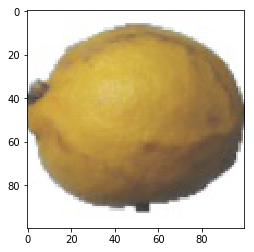

In [5]:
temp_img = plt.imread(np.random.choice(train_images))
plt.imshow(temp_img)

In [6]:
vgg = VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [7]:
for layer in vgg.layers:
    layer.trainable = False
    
x = Flatten()(vgg.output)
predictions = Dense(len(folders),activation='softmax')(x)

In [8]:
model = Model(inputs=vgg.inputs,outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [9]:
model.compile(loss='categorical_crossentropy',optimizer= 'rmsprop',metrics = ['accuracy'])

In [10]:
gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    preprocessing_function = preprocess_input
)

In [11]:
test_gen = gen.flow_from_directory(valid_path,target_size=IMAGE_SIZE)

Found 1289 images belonging to 8 classes.


In [12]:
print(test_gen.class_indices)

{'Apple Golden 1': 0, 'Kiwi': 3, 'Lemon': 4, 'Avocado': 1, 'Strawberry': 7, 'Mango': 5, 'Raspberry': 6, 'Banana': 2}


In [13]:
labels = [None]*len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v] = k

Min :  -102.939 Max :  151.061


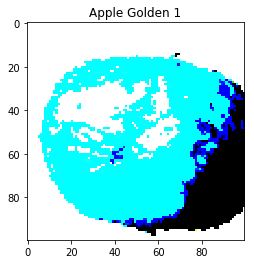

In [14]:
for x,y in test_gen:
    print('Min : ',x[0].min(),'Max : ',x[0].max())
    plt.imshow(x[0])
    plt.title(labels[np.argmax(y[0])])
    break

In [15]:
#training data image generator
train_gen = gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)


#valid data generator
valid_gen = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

Found 3839 images belonging to 8 classes.
Found 1289 images belonging to 8 classes.


In [16]:
r = model.fit_generator(
    train_gen,
    validation_data=valid_gen,
    epochs = n_epochs,
    steps_per_epoch = len(train_images)//batch_size,
    validation_steps = len(valid_images)//batch_size
)

Epoch 1/5
119/119 [==============================] - 1330s 11s/step - loss: 4.1583 - acc: 0.7329 - val_loss: 2.3558 - val_acc: 0.8266
Epoch 2/5
119/119 [==============================] - 1325s 11s/step - loss: 1.8352 - acc: 0.8839 - val_loss: 1.8184 - val_acc: 0.8844
Epoch 3/5
119/119 [==============================] - 1319s 11s/step - loss: 1.7683 - acc: 0.8899 - val_loss: 1.7525 - val_acc: 0.8898
Epoch 4/5
119/119 [==============================] - 1316s 11s/step - loss: 1.8339 - acc: 0.8858 - val_loss: 1.8098 - val_acc: 0.8859
Epoch 5/5
119/119 [==============================] - 1322s 11s/step - loss: 1.7469 - acc: 0.8915 - val_loss: 1.7728 - val_acc: 0.8891


In [26]:
import pickle
f = open('r.pickle','w')
pickle.dump(r.history,f)
f.close()

In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
def get_confusion_matrix(data_path,N):
    print('generating confusion matrix ',N)
    preds = []
    targets = []
    i = 0
    for x,y in gen.flow_from_directory(data_path,target_size=IMAGE_SIZE,shuffle=False,batch_size = batch_size*2):
        i += 1
        if i%50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p,axis=1)
        y = np.argmax(y,axis=1)
        preds = np.concatenate((preds,p))
        targets = np.concatenate((targets,y))
        if len(targets) > N:
            break        
            
    cm = confusion_matrix(targets,preds)
    return cm

In [34]:
train_cm = get_confusion_matrix(train_path,len(train_images))

generating confusion matrix  3839
Found 3839 images belonging to 8 classes.
50


In [36]:
valid_cm = get_confusion_matrix(valid_path,len(valid_images))

generating confusion matrix  1289
Found 1289 images belonging to 8 classes.


In [38]:
train_cm

array([[556,   0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   2,  48,   0, 374,   0,   1],
       [  0,   0, 490,   0,   0,   0,   0,   0],
       [  0,   0,   0, 466,   0,   0,   0,   0],
       [  0,   0,   0,   0, 492,   0,   0,   0],
       [  0,   0,   0,   0,   0, 490,   0,   0],
       [  0,   0,   0,   0,   0,   0, 490,   0],
       [  0,   0,   0,   0,   0,   0,   0, 492]])

In [39]:
valid_cm

array([[226,   0,   0,   0,   2,   0,   0,   0],
       [  5,   0,   0,  14,   1, 123,   0,   0],
       [  0,   0, 166,   0,   0,   0,   0,   0],
       [  0,   0,   0, 156,   0,   0,   0,   0],
       [  0,   0,   0,   0, 164,   0,   0,   0],
       [  0,   0,   0,   0,   0, 166,   0,   0],
       [  0,   0,   0,   0,   0,   0, 166,   0],
       [  0,   0,   0,   0,   0,   0,   0, 164]])

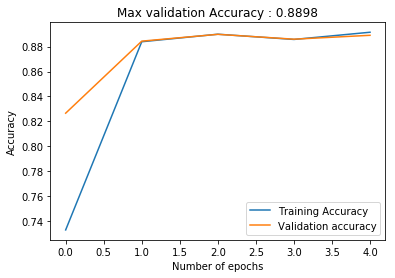

In [59]:
plt.plot(r.history['acc'],label = 'Training Accuracy')
plt.plot(r.history['val_acc'],label = 'Validation accuracy')
best_acc = max(r.history['val_acc'])
plt.title('Max validation Accuracy : {:.4f}'.format(best_acc))
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

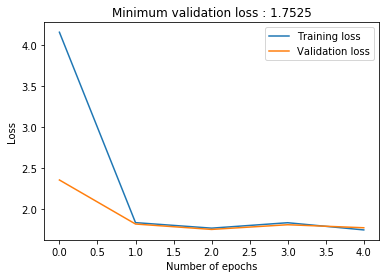

In [58]:
plt.plot(r.history['loss'],label = 'Training loss')
plt.plot(r.history['val_loss'],label = 'Validation loss')
plt.title('Minimum validation loss : {:.4f}'.format(min(r.history['val_loss'])))
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend()